<a href="https://colab.research.google.com/github/sholaypompey/project-sampling/blob/main/06_Transfer_Learning_In_Tensorflow_Part3_scalling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating helper functions

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-09 16:04:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-09 16:04:54 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, confusion_matrix, plot_loss_curves, compare_historys

# Downloading and pre-processing data

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-11-09 16:04:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  23.9MB/s    in 68s     

2022-11-09 16:06:06 (22.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_cla

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = (224, 224),
                                                                                batch_size = 32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (224, 224),
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
Checkpoint_Callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2)
], name = "data_augmentation")

# Create Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_layer_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_layer_poolin  (None, 1280)             0         
 g (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_1 = model_1.fit(train_data_all_10_percent,
            epochs = 5,
            validation_data = test_data,
            validation_steps = int(0.15 * len(test_data)),
            callbacks = [Checkpoint_Callback])

Epoch 1/5
237/237 [==============================] - 93s 332ms/step - loss: 3.3847 - accuracy: 0.2726 - val_loss: 2.5536 - val_accuracy: 0.4272
Epoch 2/5
237/237 [==============================] - 64s 268ms/step - loss: 2.2087 - accuracy: 0.4970 - val_loss: 2.0835 - val_accuracy: 0.4936
Epoch 3/5
237/237 [==============================] - 60s 249ms/step - loss: 1.8366 - accuracy: 0.5621 - val_loss: 1.9055 - val_accuracy: 0.5127
Epoch 4/5
237/237 [==============================] - 56s 237ms/step - loss: 1.6057 - accuracy: 0.6145 - val_loss: 1.8400 - val_accuracy: 0.5257
Epoch 5/5
237/237 [==============================] - 53s 224ms/step - loss: 1.4498 - accuracy: 0.6434 - val_loss: 1.7836 - val_accuracy: 0.5358


In [ ]:
feature_extraction_model_results = model_1.evaluate(test_data)
feature_extraction_model_results

790/790 [==============================] - 60s 76ms/step - loss: 1.5819 - accuracy: 0.5822


[1.5819240808486938, 0.582217812538147]

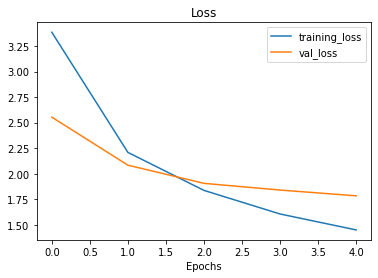

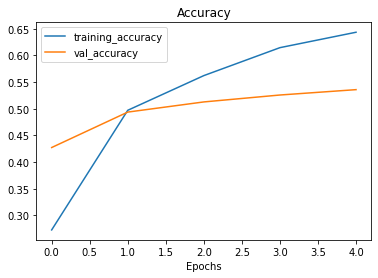

In [ ]:
plot_loss_curves(history_1)

## Fine tune the model

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
len(base_model.layers)

238

In [ ]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(0.0001),
                metrics = ["accuracy"])
fine_tune_epochs = 10
history_finetune = model_1.fit(train_data_all_10_percent,
                               epochs = fine_tune_epochs,
                               validation_data = test_data,
                               validation_steps = int(0.15 * len(test_data)),
                               initial_epoch = history_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 61s 227ms/step - loss: 1.2062 - accuracy: 0.6854 - val_loss: 1.7444 - val_accuracy: 0.5434
Epoch 6/10
237/237 [==============================] - 49s 206ms/step - loss: 1.0938 - accuracy: 0.7028 - val_loss: 1.7282 - val_accuracy: 0.5519
Epoch 7/10
237/237 [==============================] - 46s 194ms/step - loss: 1.0256 - accuracy: 0.7294 - val_loss: 1.7023 - val_accuracy: 0.5580
Epoch 8/10
237/237 [==============================] - 47s 196ms/step - loss: 0.9508 - accuracy: 0.7467 - val_loss: 1.7248 - val_accuracy: 0.5532
Epoch 9/10
237/237 [==============================] - 46s 191ms/step - loss: 0.8912 - accuracy: 0.7593 - val_loss: 1.6968 - val_accuracy: 0.5583
Epoch 10/10
237/237 [==============================] - 55s 229ms/step - loss: 0.8380 - accuracy: 0.7743 - val_loss: 1.7149 - val_accuracy: 0.5559


In [ ]:
result_all_fine_tune = model_1.evaluate(test_data)
result_all_fine_tune

790/790 [==============================] - 77s 97ms/step - loss: 1.4842 - accuracy: 0.6065


[1.4842033386230469, 0.6064554452896118]

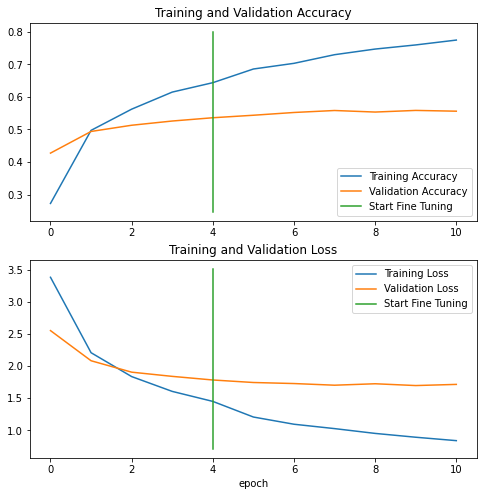

In [ ]:
compare_historys(original_history = history_1,
                 new_history = history_finetune,
                 initial_epochs = 5)

In [ ]:
model_1.save("content/drive/MyDrive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

# Evaluating the performance of the big dog model on all different classes

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2022-11-09 16:23:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  15.1MB/s    in 2.9s    

2022-11-09 16:23:33 (15.1 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# Check if the loaded model is a trained model 
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 67s 83ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

In [ ]:
pred_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 69s 85ms/step


In [ ]:
pred_probs[0], len(pred_probs[0]), pred_probs[0].argmax(), pred_probs[0].sum(), pred_probs.shape

(array([5.9542041e-02, 3.5742053e-06, 4.1376803e-02, 1.0660536e-09,
        8.1613978e-09, 8.6639664e-09, 8.0927055e-07, 8.5652584e-07,
        1.9859037e-05, 8.0977844e-07, 3.1727685e-09, 9.8673934e-07,
        2.8532150e-04, 7.8048906e-10, 7.4230199e-04, 3.8916383e-05,
        6.4740493e-06, 2.4977257e-06, 3.7891168e-05, 2.0678289e-07,
        1.5538468e-05, 8.1507341e-07, 2.6230621e-06, 2.0010727e-07,
        8.3827535e-07, 5.4215934e-06, 3.7391037e-06, 1.3150533e-08,
        2.7761499e-03, 2.8051867e-05, 6.8562162e-10, 2.5574906e-05,
        1.6688929e-04, 7.6407003e-10, 4.0452901e-04, 1.3150634e-08,
        1.7957395e-06, 1.4448203e-06, 2.3062935e-02, 8.2466863e-07,
        8.5365861e-07, 1.7138630e-06, 7.0525307e-06, 1.8402273e-08,
        2.8553430e-07, 7.9483771e-06, 2.0681496e-06, 1.8525223e-07,
        3.3619774e-08, 3.1522568e-04, 1.0410943e-05, 8.5448448e-07,
        8.4741873e-01, 1.0555466e-05, 4.4094878e-07, 3.7404185e-05,
        3.5306264e-05, 3.2489010e-05, 6.7314875e

In [ ]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis = 1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

## Unbatch the test data to enable comparasion with the predicted label

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Use sckit-learn metrics to evaluate our model
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
import numpy as np
np.isclose(loaded_accuracy, sklearn_accuracy)

True

In [ ]:
conf_matrix = confusion_matrix(y_true = y_labels, y_pred = pred_classes)
conf_matrix

array([[ 51,   1,  25, ...,   5,   0,  16],
       [  0, 173,   0, ...,   0,   0,   0],
       [  8,   2, 162, ...,   1,   0,   3],
       ...,
       [  1,   0,   5, ...,  82,   0,   0],
       [  0,   1,   0, ...,   0,  67,   0],
       [  2,   0,   0, ...,   2,   0, 175]])

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(50, 50), text_size=20, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

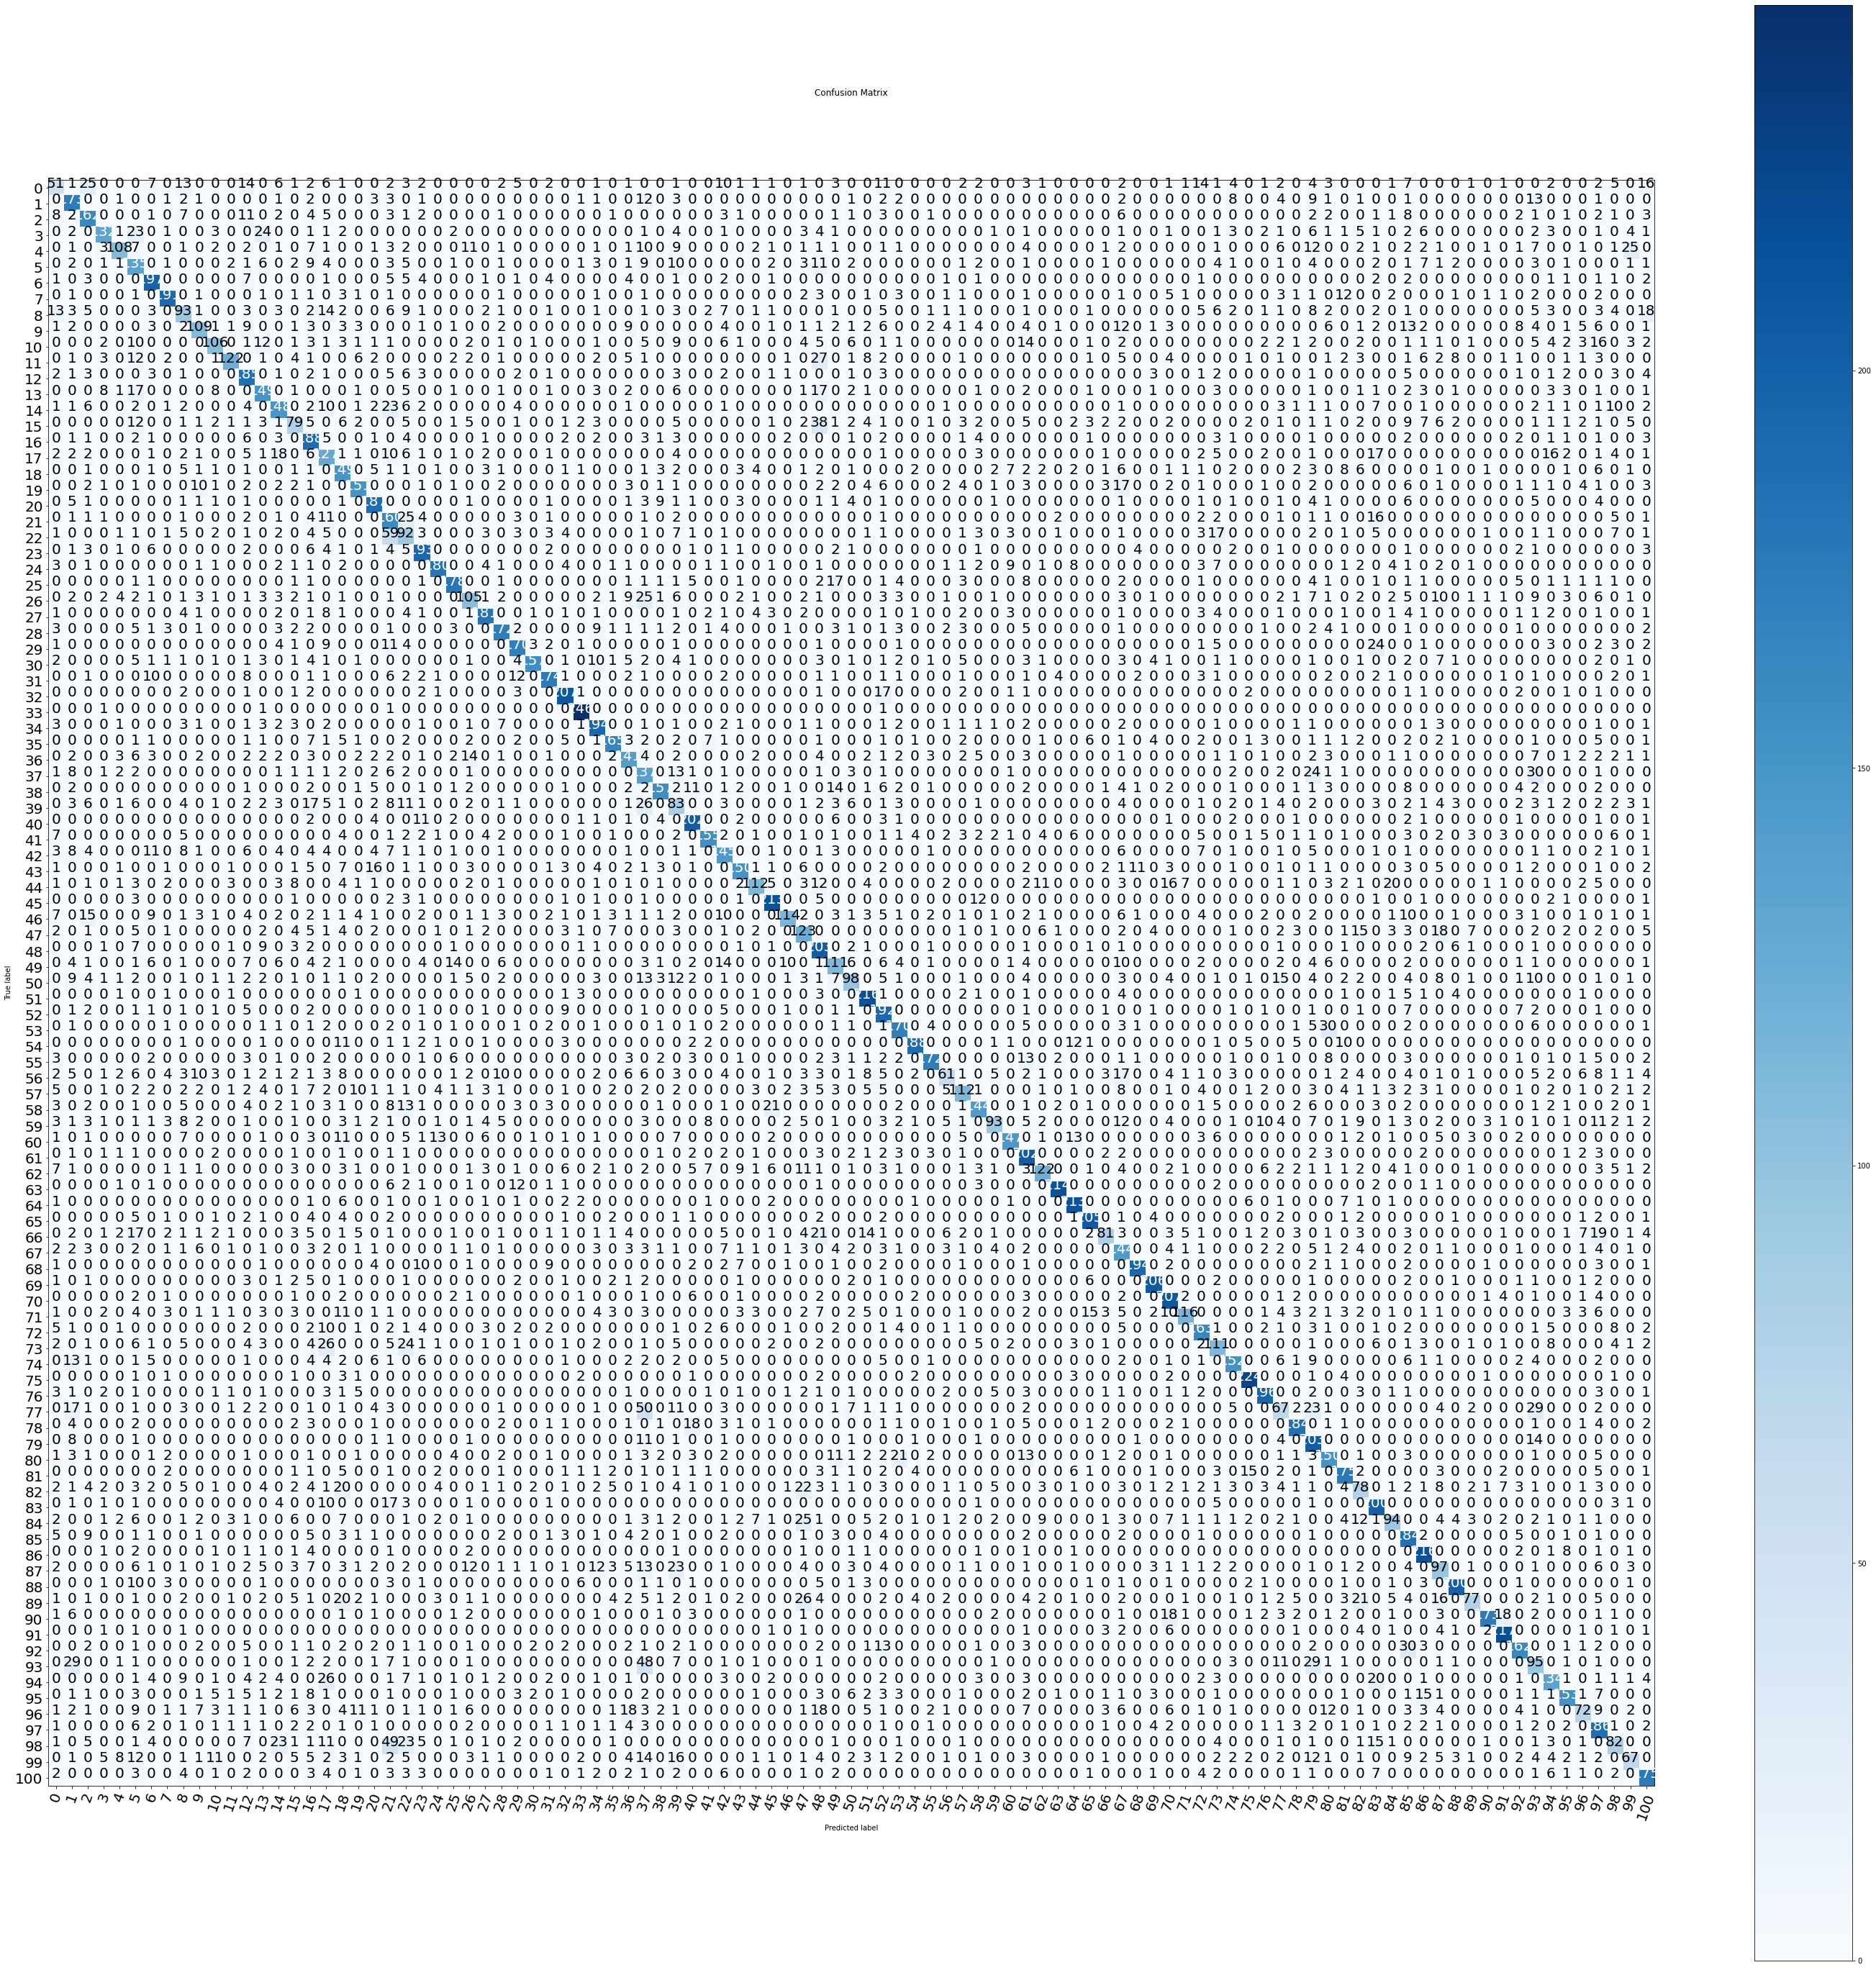

In [ ]:
make_confusion_matrix(y_labels, pred_classes)

In [ ]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

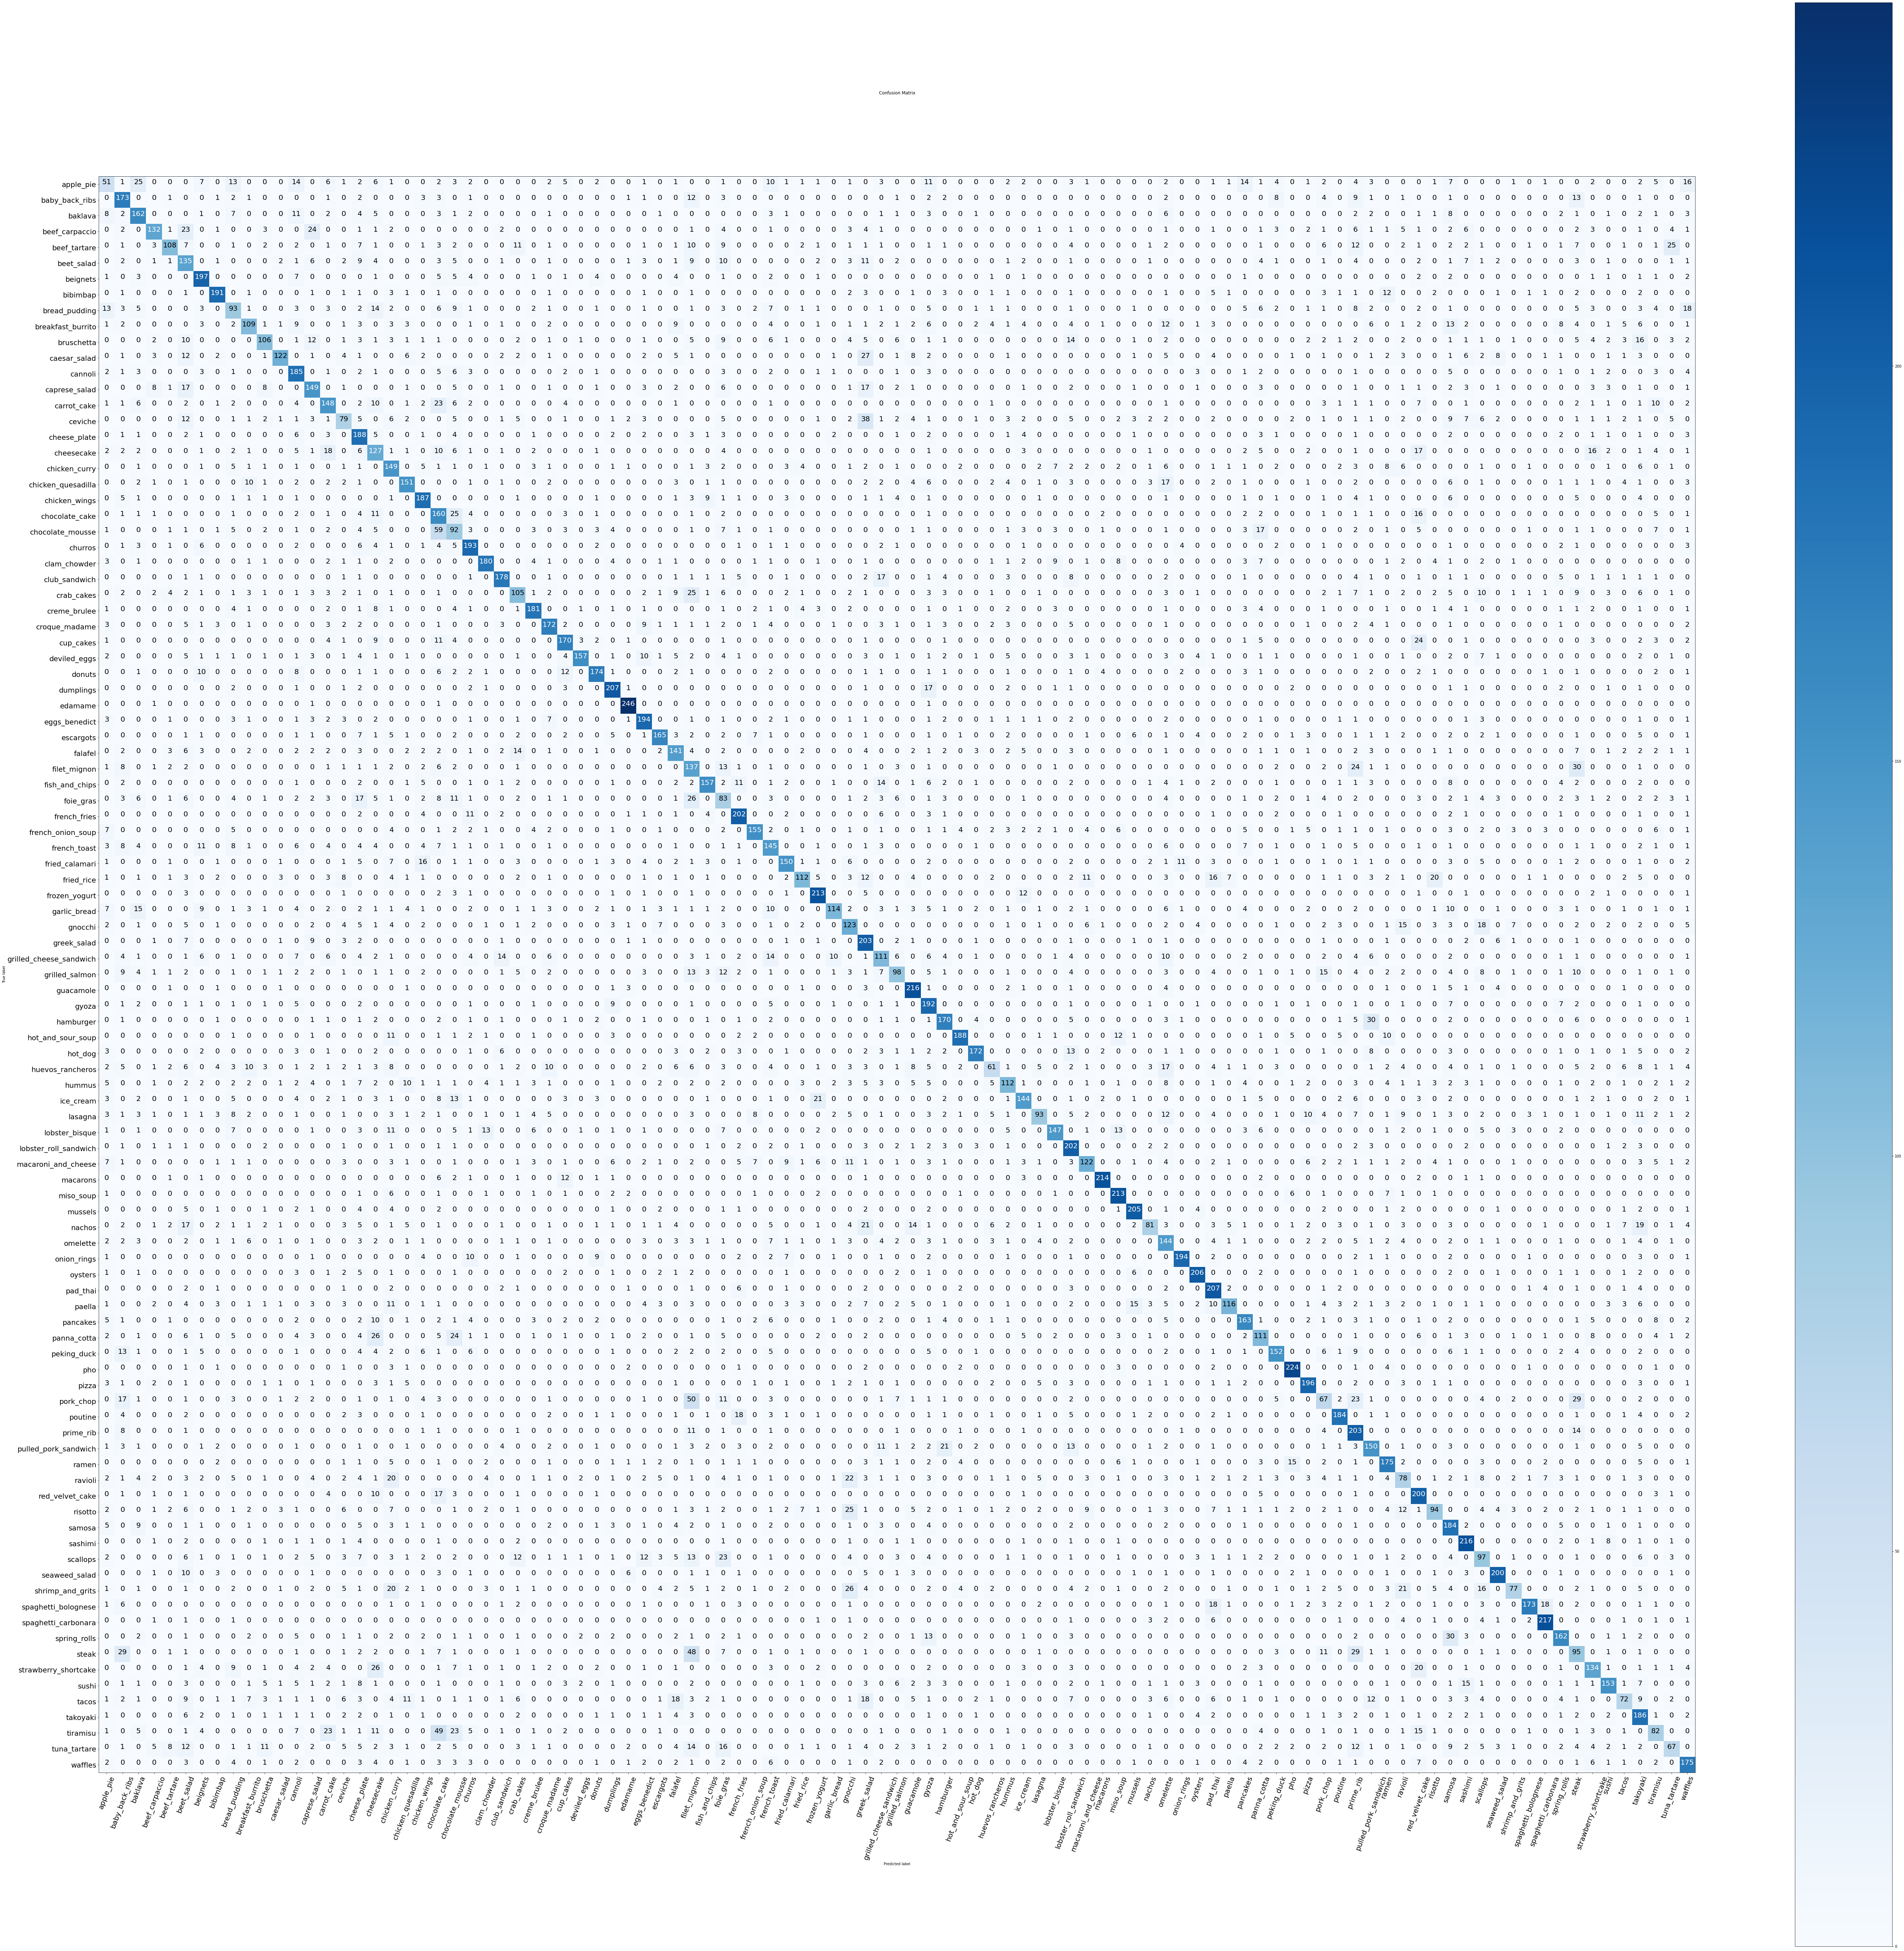

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict= True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [ ]:
# Create a dictionary of the classification class
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)
f1_scores

class_name  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

## Plot a horizontal bar chart

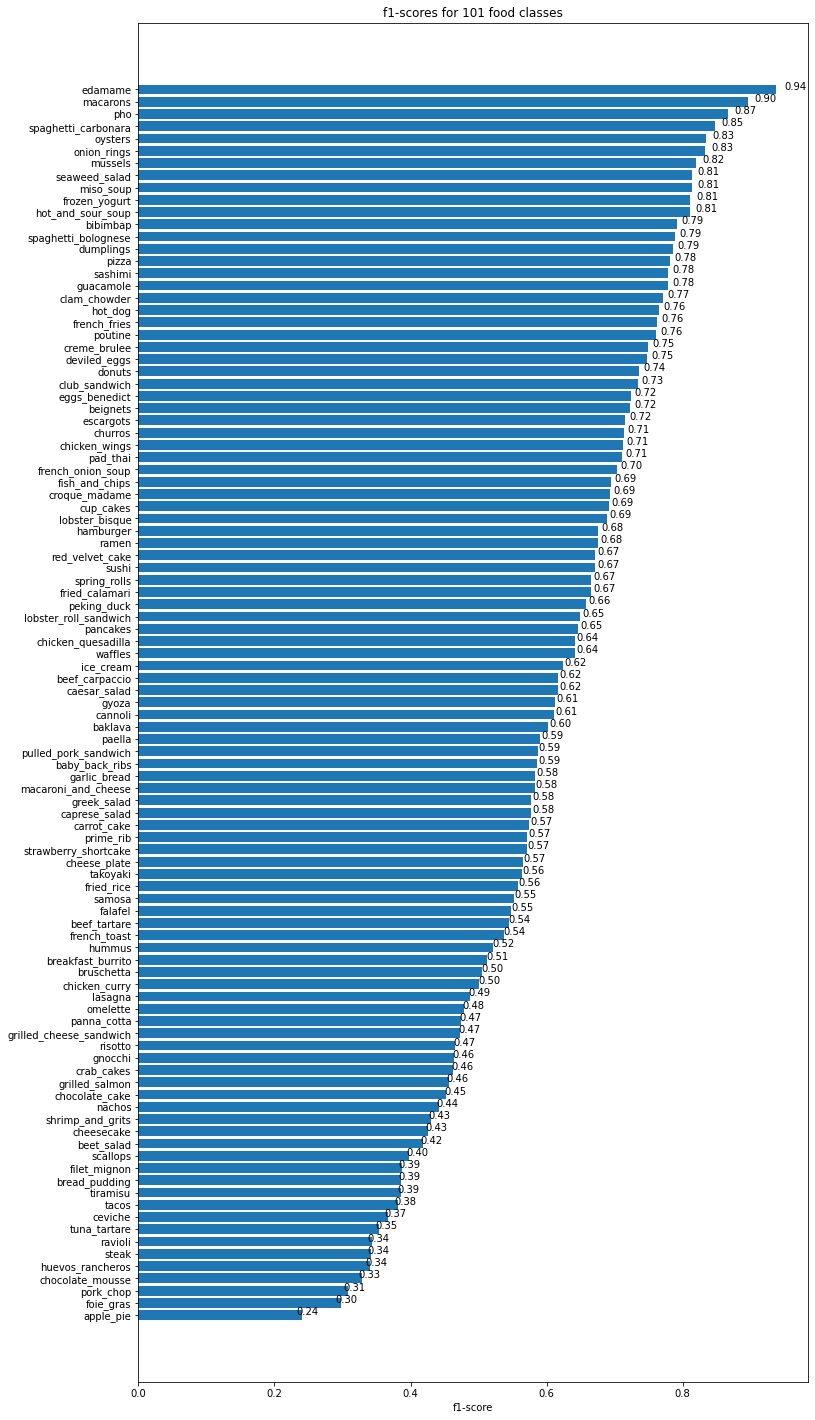

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize= (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("f1-scores for 101 food classes")
ax.invert_yaxis()

def autolabel(rects):

  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5, f"{width:.2f}", ha = "center", va = "bottom")
autolabel(scores)



# Visualizing predictions on test images

In [ ]:
# Define a function to load and prepare images
def load_and_prep_image(filename, image_size = 224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [image_size, image_size])
  if scale:
    return (img/255.)
  else:
    return(img)

1/1 [==============================] - 0s 25ms/step


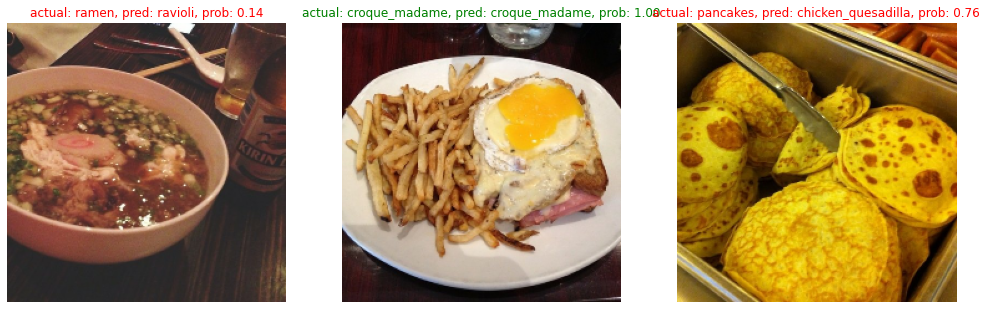

In [ ]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + class_name))
  filepath = test_dir + class_name + "/" + filename

# Load and prepare the image
  img = load_and_prep_image(filepath, scale= False)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_prob.argmax()]

# Plot the image
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if pred_class == class_name:
    title_colour = "g"
  else:
    title_colour = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c= title_colour)
  plt.axis(False);

## Finding the most wrong predictions

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# Create a DataFrrame out of current predictions for analysis
pred_df = pd.DataFrame({
    "image_paths": filepaths,
    "y_true": y_labels,
    "y_preds": pred_classes,
    "pred_conf": pred_probs.max(axis = 1),
    "true_class": [class_names[i] for i in y_labels],
    "pred_class": [class_names[i] for i in pred_classes]
})
pred_df[:10]

image_paths  y_true  y_preds  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0        0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0        0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       79   
5  b'101_food_classes_10_percent/test/apple_pie/1...       0       61   
6  b'101_food_classes_10_percent/test/apple_pie/1...       0       29   
7  b'101_food_classes_10_percent/test/apple_pie/1...       0        0   
8  b'101_food_classes_10_percent/test/apple_pie/1...       0       85   
9  b'101_food_classes_10_percent/test/apple_pie/1...       0        0   

   pred_conf true_class             pred_class  
0   0.847419  apple_pie                  gyoza  
1   0.964017  apple_pie              apple_pie  
2   0.959259  apple_pie              apple_pie  
3   0.658606  apple_pie   pulled_pork_sandwich  
4   0.367901  apple_pie              prime_rib  
5   0.456755  apple_pie  lobster_roll_sandwich  
6   0.611243  apple_pie              cup_cakes  
7   0.473133  apple_pie              apple_pie  
8   0.245396  apple_pie                 samosa  
9   0.724390  apple_pie              apple_pie

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_preds"]
pred_df.head()

image_paths  y_true  y_preds  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0        0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0        0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       79   

   pred_conf true_class            pred_class  pred_correct  
0   0.847419  apple_pie                 gyoza         False  
1   0.964017  apple_pie             apple_pie          True  
2   0.959259  apple_pie             apple_pie          True  
3   0.658606  apple_pie  pulled_pork_sandwich         False  
4   0.367901  apple_pie             prime_rib         False

In [ ]:
Top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)[:100]
Top_100_wrong.head(20)

image_paths  y_true  y_preds  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87       29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0      100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61       53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94       83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85       92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98       83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10       61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22       21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71       65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95       86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72       67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46       10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43       68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94       83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4        5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43       68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95       86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29       83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52       92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43       68   

       pred_conf             true_class             pred_class  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

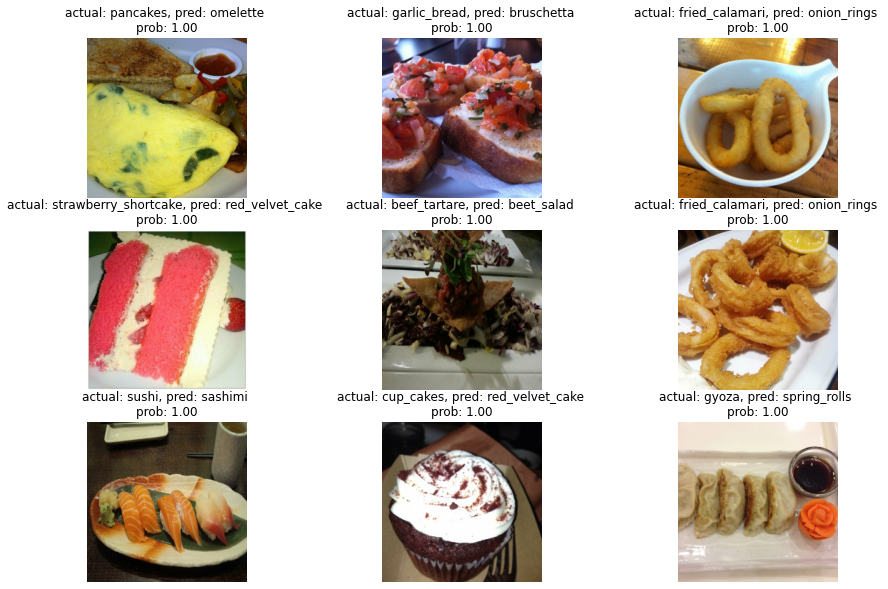

In [ ]:
# Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(Top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)